In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json

import sequence_jacobian as sj # sequence-space Jacobian toolkit

from household import hh_ha, hh_ta, hh_ra

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})


Use the author's code to generate the general equilibrium

## Block for GE

### Production

In [3]:
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y               # production technology (to first order, i.e. ignoring any Calvo or Rotemberg distortion)
    wN = Y / mu
    div = Y - wN
    return N, wN, div

In [4]:
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.simple
def nom_ST_bonds(r_ante, pi):
    """Bond returns if bonds are short term and nominal"""
    # real return adjusted downward by any excess of expected over actual inflation
    pi_e = pi(1)
    r_post_bonds = (1 + r_ante(-1)) * (1 + pi_e(-1))/(1 + pi) - 1
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.solved(unknowns={'qbond': (0.001, 100.)}, targets=['q_res'], solver="brentq")
def real_LT_bonds(qbond, r_ante, delta):
    """Bond returns if bonds are long term and real"""
    # equation for end-of-period price q of stream of future coupons (1,delta,delta^2,...): q_res=0
    q_res = qbond - (1 + delta * qbond(+1)) / (1 + r_ante)

    # ex-post return on bonds is coupon today plus delta times value of remaining coupon stream
    # divided by yesterday's end-of-period price
    r_post_bonds = (1 + delta * qbond) / qbond(-1) - 1
    return r_post_bonds, q_res

### Fiscal policy


In [5]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

In [6]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

In [7]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

In [8]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

In [9]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

In [10]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

In [11]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

In [12]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

1.1142857142857143

In [13]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

In [14]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

In [15]:
ss = {}

In [16]:
with open('hh_params.json') as f:
    ha_params = json.load(f)

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']

(8.29558643999917e-12, 5.881724611800365e-07, -2.220446049250313e-18)

In [17]:
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

In [18]:
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

In [19]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

In [20]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

In [21]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y'], targets=['asset_mkt'],
                                            inputs={'B': dB}, outputs=['Y'], Js=Js)['Y'] for k in model_names}

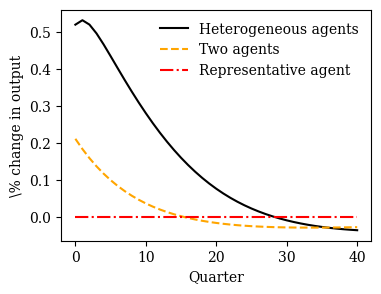

In [22]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

### Figure 2b

In [26]:
common_blocks_richest = common_blocks.copy()
common_blocks_richest[2] = fiscal_richest
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

In [27]:
ss_taylor = ss['ha'].copy()
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])
irf_B_taylor = model_ha_taylor.solve_impulse_linear(ss_taylor, unknowns=['Y', 'pi'], targets=['asset_mkt', 'nkpc_res'],
                                               inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']

In [28]:
irf_B_ALW = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y', 'B'], targets=['asset_mkt', 'tax_rate_res'],
                                             inputs={'tax_rate_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']

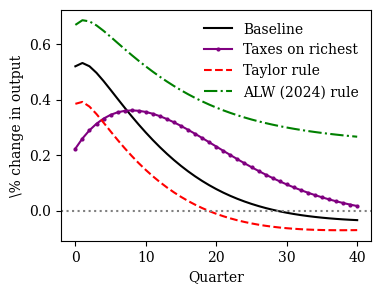

In [29]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')

### Plot the IRF

We computed the Impulse Response Functions (IRFs) for a deficit-financed tax cut.

To do this, we first determined the distribution cutoffs at the Steady State for four specific groups: the Top 1%, the Top 10%, the Bottom 50%, and the remaining Middle 40% (Upper Middle Class). We then tracked the evolution of the wealth held by these groups after the shock. This allows us to observe the response across the entire distribution.

It is important to note that these groups are defined statically, based on the pre-shock Steady State. This means the analysis does not account for agents moving from one bracket of the distribution to another during the transition. Therefore, the "Top 1%" refers to the households that were in the Top 1% before the shock. However, given the high persistence of productivity in the model, this approach provides significant insights into the winners and losers of the policy.

We constructed 4 plots to visualize these dynamics:

Wealth Variation: The percentage change in absolute wealth for each group.

Wealth Share Variation: The change in the portion of total wealth held by each group (in percentage points).

Top 1% Share: The evolution of the wealth share specifically for the top percentile.

Output Response: The aggregate GDP response (to ensure consistency with the replication results).

Seuils de Richesse : Top 1% >= 302.7, Top 10% >= 48.8, Médiane = 1.2
Calcul de l'IRF en cours...


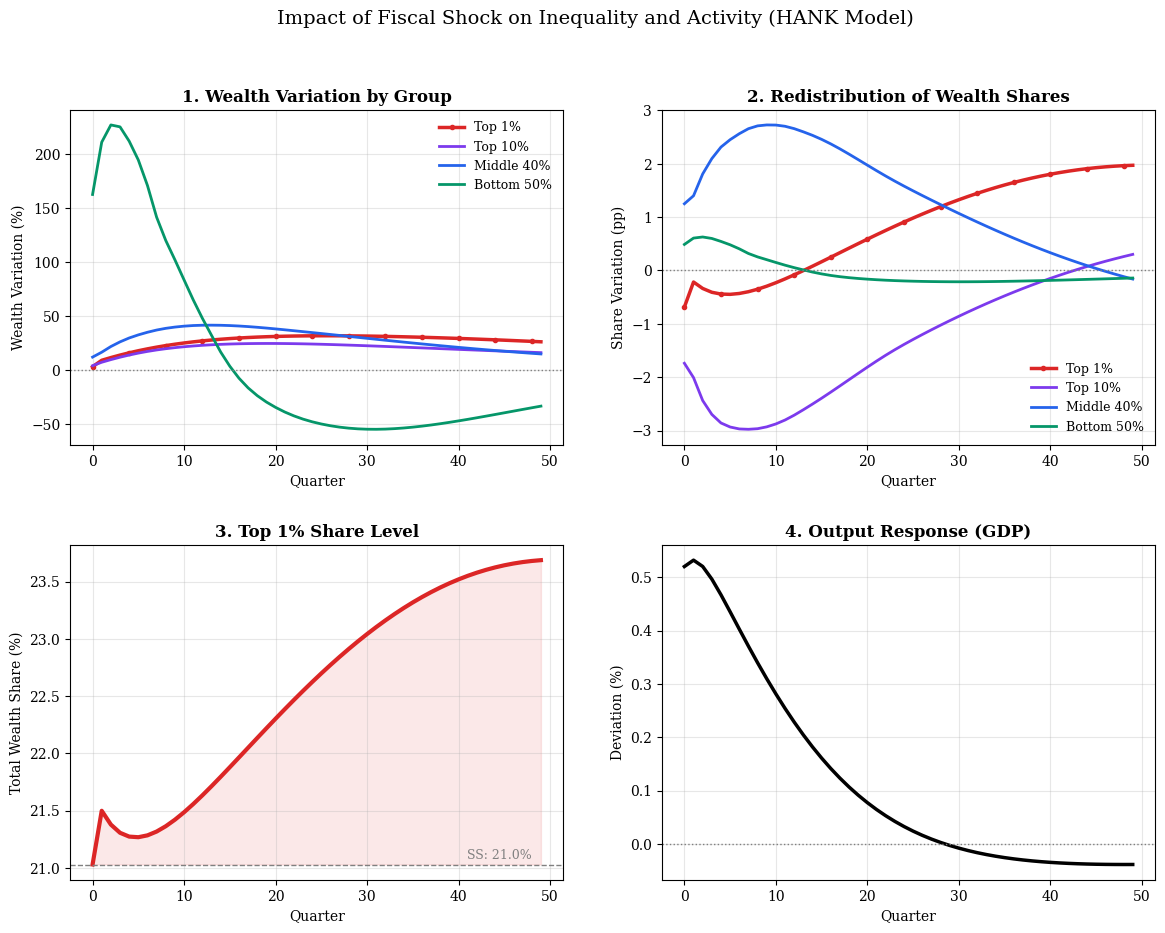

In [38]:
from household import hh_raw, make_grids, income, hh_ha

# ============================================================================
# 1. CALCUL DES SEUILS (FIXES AU STEADY STATE)
# ============================================================================

hh_internals = ss['ha'].internals['hh_ha']
a_grid = hh_internals['a_grid']
D_ss = hh_internals['D']

# Distribution marginale de la richesse
if D_ss.ndim > 1:
    D_a = D_ss.sum(axis=tuple(range(D_ss.ndim - 1)))
else:
    D_a = D_ss.reshape(-1, len(a_grid)).sum(axis=0)


def get_cutoff(percentile, dist, grid):
    cdf = np.cumsum(dist)
    idx = np.searchsorted(cdf, percentile)
    return grid[idx]

cut_1 = get_cutoff(0.99, D_a, a_grid)
cut_10 = get_cutoff(0.90, D_a, a_grid)
cut_50 = get_cutoff(0.50, D_a, a_grid)

print(f"Seuils de Richesse : Top 1% >= {cut_1:.1f}, Top 10% >= {cut_10:.1f}, Médiane = {cut_50:.1f}")

# ============================================================================
# 2. DÉFINITION DU BLOC MÉNAGE "INEQUALITY"
# ============================================================================


@sj.het(exogenous='Pi', policy='a', backward='Va', backward_init=sj.hetblocks.hh_sim.hh_init)

def hh_wealth_groups(Va_p, a_grid, y, r, beta, eis, cut_1, cut_10, cut_50):
    """Bloc hétérogène qui suit la richesse par groupe (Seuils fixes)"""
    # 1. Équation d'Euler Standard (Même logique que hh_ha)
    uc_nextgrid = beta[:, np.newaxis] * Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + y[:, np.newaxis]
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    sj.misc.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    
    # 2. Calcul des richesses par groupe
    wealth_top1 = np.where(a >= cut_1, a, 0)
    wealth_top10 = np.where(a >= cut_10, a, 0)
    wealth_mid40 = np.where((a >= cut_50) & (a < cut_10), a, 0)
    wealth_bot50 = np.where(a < cut_50, a, 0)
    
    # SSJ va agréger ces variables automatiquement (somme pondérée par D)
    return Va, a, c, wealth_top1, wealth_top10, wealth_mid40, wealth_bot50

# Ajout des inputs hétérogènes (C'est ici que ça plantait avant sans l'import)
hh_wealth_groups = hh_wealth_groups.add_hetinputs([make_grids, income])

# ============================================================================
# 3. CRÉATION DU MODÈLE ET SIMULATION
# ============================================================================

# On combine avec les blocs macro existants
model_wealth = sj.combine([production, real_ST_bonds, fiscal, capitalization, 
                           ex_post_r, nkpc, mkt_clearing, hh_wealth_groups])

# On met à jour le Steady State pour le nouveau modèle
ss_wealth = ss['ha'].copy()
ss_wealth.update({'cut_1': cut_1, 'cut_10': cut_10, 'cut_50': cut_50})
ss_wealth = model_wealth.steady_state(ss_wealth)


print("Calcul de l'IRF en cours...")
irf_wealth = model_wealth.solve_impulse_linear(
    ss_wealth,
    unknowns=['Y'],
    targets=['asset_mkt'],
    inputs={'B': dB},
    outputs=['Y', 'A', 'WEALTH_TOP1', 'WEALTH_TOP10', 'WEALTH_MID40', 'WEALTH_BOT50']
)

# ============================================================================
# 4. CALCUL DES PARTS (SHARES)
# ============================================================================

# Niveaux SS
A_ss = ss_wealth['A']
W1_ss = ss_wealth['WEALTH_TOP1']
W10_ss = ss_wealth['WEALTH_TOP10']
Wm40_ss = ss_wealth['WEALTH_MID40']
Wb50_ss = ss_wealth['WEALTH_BOT50']

# Trajectoires dynamiques (Niveaux)
A_path = A_ss + irf_wealth['A']
W1_path = W1_ss + irf_wealth['WEALTH_TOP1']
W10_path = W10_ss + irf_wealth['WEALTH_TOP10']
Wm40_path = Wm40_ss + irf_wealth['WEALTH_MID40']
Wb50_path = Wb50_ss + irf_wealth['WEALTH_BOT50']

# Parts dynamiques (%)
share_top1 = 100 * W1_path / A_path
share_top10 = 100 * W10_path / A_path
share_mid40 = 100 * Wm40_path / A_path
share_bot50 = 100 * Wb50_path / A_path

Share_1_ss = 100 * W1_ss / A_ss
Share_10_ss = 100 * W10_ss / A_ss
Share_m40_ss = 100 * Wm40_ss / A_ss
Share_b50_ss = 100 * Wb50_ss / A_ss

# 3. Calcul de la Variation (Points de pourcentage pp)

share_top1_ch = share_top1 - Share_1_ss
share_top10_ch = share_top10 - Share_10_ss
share_mid40_ch = share_mid40 - Share_m40_ss
share_bot50_ch = share_bot50 - Share_b50_ss

# ============================================================================
# 5. VISUALISATION (4 GRAPHIQUES)
horizon = 50
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# --- Graph 1: Wealth Variation (%) ---
ax1 = axes[0, 0]
ax1.plot(100 * (W1_path / W1_ss - 1)[:horizon], label='Top 1%', color='#dc2626', linewidth=2.5, marker='o', markersize=3, markevery=4)
ax1.plot(100 * (W10_path / W10_ss - 1)[:horizon], label='Top 10%', color='#7c3aed', linewidth=2)
ax1.plot(100 * (Wm40_path / Wm40_ss - 1)[:horizon], label='Middle 40%', color='#2563eb', linewidth=2)
ax1.plot(100 * (Wb50_path / Wb50_ss - 1)[:horizon], label='Bottom 50%', color='#059669', linewidth=2)
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)
ax1.set_xlabel('Quarter', fontsize=10)
ax1.set_ylabel('Wealth Variation (%)', fontsize=10)
ax1.set_title('1. Wealth Variation by Group', fontsize=12, fontweight='bold')
ax1.legend(loc='best', frameon=False, fontsize=9)
ax1.grid(alpha=0.3)

# --- Graph 2: Wealth Share Variation (pp) ---
ax2 = axes[0, 1]
ax2.plot(share_top1_ch[:horizon], label='Top 1%', color='#dc2626', linewidth=2.5, marker='o', markersize=3, markevery=4)
ax2.plot(share_top10_ch[:horizon], label='Top 10%', color='#7c3aed', linewidth=2)
ax2.plot(share_mid40_ch[:horizon], label='Middle 40%', color='#2563eb', linewidth=2)
ax2.plot(share_bot50_ch[:horizon], label='Bottom 50%', color='#059669', linewidth=2)
ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
ax2.set_xlabel('Quarter', fontsize=10)
ax2.set_ylabel('Share Variation (pp)', fontsize=10)
ax2.set_title('2. Redistribution of Wealth Shares', fontsize=12, fontweight='bold')
ax2.legend(loc='best', frameon=False, fontsize=9)
ax2.grid(alpha=0.3)

# --- Graph 3: Top 1% Share (Absolute Level) ---
ax3 = axes[1, 0]
ax3.plot(share_top1[:horizon], color='#dc2626', linewidth=3)
ax3.fill_between(np.arange(horizon), share_top1[0], share_top1[:horizon], alpha=0.1, color='#dc2626')
ax3.axhline(share_top1[0], color='gray', linestyle='--', linewidth=1, label='Steady State')
ax3.set_xlabel('Quarter', fontsize=10)
ax3.set_ylabel('Total Wealth Share (%)', fontsize=10)
ax3.set_title('3. Top 1% Share Level', fontsize=12, fontweight='bold')
ax3.text(horizon-2, share_top1[0]+0.05, f'SS: {share_top1[0]:.1f}%', fontsize=9, ha='right', color='gray')
ax3.grid(alpha=0.3)

# --- Graph 4: Output Response (Y) ---
ax4 = axes[1, 1]
ax4.plot(irf_wealth['Y'][:horizon], color='black', linewidth=2.5)
ax4.axhline(0, color='gray', linestyle=':', linewidth=1)
ax4.set_xlabel('Quarter', fontsize=10)
ax4.set_ylabel('Deviation (%)', fontsize=10)
ax4.set_title('4. Output Response (GDP)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.suptitle("Impact of Fiscal Shock on Inequality and Activity (HANK Model)", fontsize=14, y=0.98)
plt.savefig('figures/irf_wealth_inequality_4plots_eng.pdf', dpi=300, bbox_inches='tight')
plt.show()

We also ran a second experiment using a 'taxes on the richest' rule. In this scenario, the richest households receive the initial tax cut and pay for the debt repayment later

Calcul de l'IRF avec fiscal_richest...


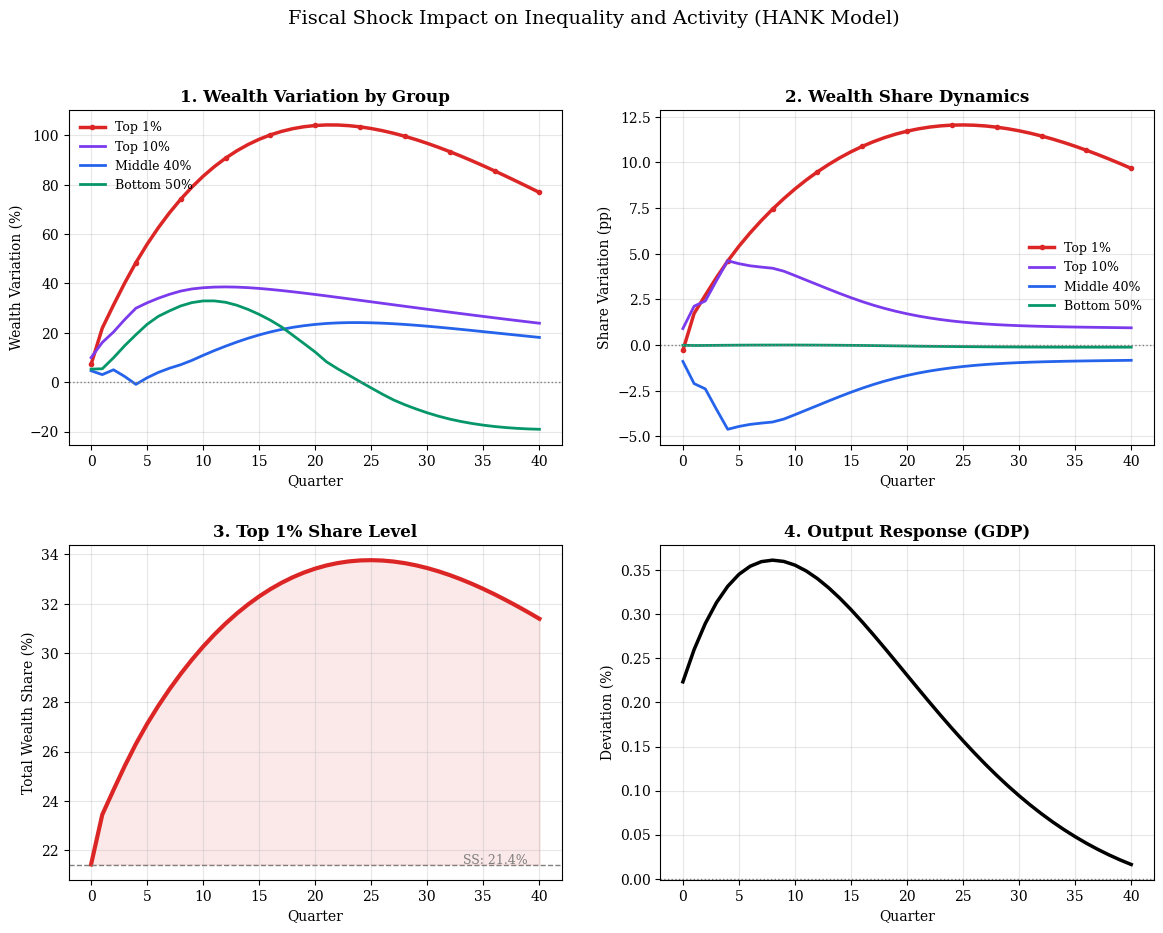

In [36]:

model_wealth = sj.combine([production, real_ST_bonds, fiscal_richest, capitalization, 
                           ex_post_r, nkpc, mkt_clearing, hh_wealth_groups])

# Mise à jour du SS avec les nouveaux paramètres de seuils
ss_wealth = ss['ha'].copy()
ss_wealth.update({'cut_1': cut_1, 'cut_10': cut_10, 'cut_50': cut_50})

# On recalcule le SS (important car fiscal_richest peut changer l'interprétation des résidus)
ss_wealth = model_wealth.steady_state(ss_wealth)

print("Calcul de l'IRF avec fiscal_richest...")
irf_wealth = model_wealth.solve_impulse_linear(
    ss_wealth,
    unknowns=['Y'],
    targets=['asset_mkt'],
    inputs={'B': dB}, # dB doit être défini précédemment (choc de dette)
    outputs=['Y', 'A', 'WEALTH_TOP1', 'WEALTH_TOP10', 'WEALTH_MID40', 'WEALTH_BOT50']
)

# ============================================================================
# 4. CALCUL DES PARTS (SHARES)
# ============================================================================

# Steady State
A_ss = ss_wealth['A']
W1_ss = ss_wealth['WEALTH_TOP1']
W10_ss = ss_wealth['WEALTH_TOP10']
Wm40_ss = ss_wealth['WEALTH_MID40']
Wb50_ss = ss_wealth['WEALTH_BOT50']

# Chemins (Paths)
A_path = A_ss + irf_wealth['A']
W1_path = W1_ss + irf_wealth['WEALTH_TOP1']
W10_path = W10_ss + irf_wealth['WEALTH_TOP10']
Wm40_path = Wm40_ss + irf_wealth['WEALTH_MID40']
Wb50_path = Wb50_ss + irf_wealth['WEALTH_BOT50']

# Calcul des parts dynamiques (%)
share_top1 = 100 * W1_path / A_path
share_top10 = 100 * W10_path / A_path
share_mid40 = 100 * Wm40_path / A_path
share_bot50 = 100 * Wb50_path / A_path

# Calcul des Parts au Steady State (Avant le choc)
Share_1_ss = 100 * W1_ss / A_ss
Share_10_ss = 100 * W10_ss / A_ss
Share_m40_ss = 100 * Wm40_ss / A_ss
Share_b50_ss = 100 * Wb50_ss / A_ss


#Calcul de la Variation (Points de pourcentage pp)
share_top1_ch = share_top1 - Share_1_ss
share_top10_ch = share_top10 - Share_10_ss
share_mid40_ch = share_mid40 - Share_m40_ss
share_bot50_ch = share_bot50 - Share_b50_ss

# ============================================================================
# 5. GRAPHIQUES
# ============================================================================
horizon = 41
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# --- Graph 1: Absolute Wealth Variation (%) ---
ax1 = axes[0, 0]
ax1.plot(100 * (W1_path / W1_ss - 1)[:horizon], label='Top 1%', color='#dc2626', linewidth=2.5, marker='o', markersize=3, markevery=4)
ax1.plot(100 * (W10_path / W10_ss - 1)[:horizon], label='Top 10%', color='#7c3aed', linewidth=2)
ax1.plot(100 * (Wm40_path / Wm40_ss - 1)[:horizon], label='Middle 40%', color='#2563eb', linewidth=2)
ax1.plot(100 * (Wb50_path / Wb50_ss - 1)[:horizon], label='Bottom 50%', color='#059669', linewidth=2)
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)
ax1.set_xlabel('Quarter', fontsize=10)
ax1.set_ylabel('Wealth Variation (%)', fontsize=10)
ax1.set_title('1. Wealth Variation by Group', fontsize=12, fontweight='bold')
ax1.legend(loc='best', frameon=False, fontsize=9)
ax1.grid(alpha=0.3)

# --- Graph 2: Wealth Share Variation (pp) ---
ax2 = axes[0, 1]
ax2.plot(share_top1_ch[:horizon], label='Top 1%', color='#dc2626', linewidth=2.5, marker='o', markersize=3, markevery=4)
ax2.plot(share_top10_ch[:horizon], label='Top 10%', color='#7c3aed', linewidth=2)
ax2.plot(share_mid40_ch[:horizon], label='Middle 40%', color='#2563eb', linewidth=2)
ax2.plot(share_bot50_ch[:horizon], label='Bottom 50%', color='#059669', linewidth=2)
ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
ax2.set_xlabel('Quarter', fontsize=10)
ax2.set_ylabel('Share Variation (pp)', fontsize=10)
ax2.set_title('2. Wealth Share Dynamics', fontsize=12, fontweight='bold')
ax2.legend(loc='best', frameon=False, fontsize=9)
ax2.grid(alpha=0.3)

# --- Graph 3: Top 1% Share (Absolute Level) ---
ax3 = axes[1, 0]
ax3.plot(share_top1[:horizon], color='#dc2626', linewidth=3)
ax3.fill_between(np.arange(horizon), share_top1[0], share_top1[:horizon], alpha=0.1, color='#dc2626')
ax3.axhline(share_top1[0], color='gray', linestyle='--', linewidth=1, label='Steady State')
ax3.set_xlabel('Quarter', fontsize=10)
ax3.set_ylabel('Total Wealth Share (%)', fontsize=10)
ax3.set_title('3. Top 1% Share Level', fontsize=12, fontweight='bold')
ax3.text(horizon-2, share_top1[0]+0.05, f'SS: {share_top1[0]:.1f}%', fontsize=9, ha='right', color='gray')
ax3.grid(alpha=0.3)

# --- Graph 4: Output Response (Y) --- 
ax4 = axes[1, 1]
ax4.plot(irf_wealth['Y'][:horizon], color='black', linewidth=2.5)
ax4.axhline(0, color='gray', linestyle=':', linewidth=1)
ax4.set_xlabel('Quarter', fontsize=10)
ax4.set_ylabel('Deviation (%)', fontsize=10)
ax4.set_title('4. Output Response (GDP)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.suptitle("Fiscal Shock Impact on Inequality and Activity (HANK Model)", fontsize=14, y=0.98)
plt.savefig('figures/irf_wealth_inequality_5plots_eng.pdf', dpi=300, bbox_inches='tight')
plt.show()